In [172]:
#CenSET


In [173]:
# Author: Decebal Constantin Mocanu et al.;
# Proof of concept implementation of Sparse Evolutionary Training (SET) of Multi Layer Perceptron (MLP) on CIFAR10 using Keras and a mask over weights.
# This implementation can be used to test SET in varying conditions, using the Keras framework versatility, e.g. various optimizers, activation layers, tensorflow
# Also it can be easily adapted for Convolutional Neural Networks or other models which have dense layers
# However, due the fact that the weights are stored in the standard Keras format (dense matrices), this implementation can not scale properly.
# If you would like to build and SET-MLP with over 100000 neurons, please use the pure Python implementation from the folder "SET-MLP-Sparse-Python-Data-Structures"

# This is a pre-alpha free software and was tested with Python 3.5.2, Keras 2.1.3, Keras_Contrib 0.0.2, Tensorflow 1.5.0, Numpy 1.14;
# The code is distributed in the hope that it may be useful, but WITHOUT ANY WARRANTIES; The use of this software is entirely at the user's own risk;
# For an easy understanding of the code functionality please read the following articles.

# If you use parts of this code please cite the following articles:
#@article{Mocanu2018SET,
#  author =        {Mocanu, Decebal Constantin and Mocanu, Elena and Stone, Peter and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio},
#  journal =       {Nature Communications},
#  title =         {Scalable Training of Artificial Neural Networks with Adaptive Sparse Connectivity inspired by Network Science},
#  year =          {2018},
#  doi =           {10.1038/s41467-018-04316-3}
#}

#@Article{Mocanu2016XBM,
#author="Mocanu, Decebal Constantin and Mocanu, Elena and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio",
#title="A topological insight into restricted Boltzmann machines",
#journal="Machine Learning",
#year="2016",
#volume="104",
#number="2",
#pages="243--270",
#doi="10.1007/s10994-016-5570-z",
#url="https://doi.org/10.1007/s10994-016-5570-z"
#}

#@phdthesis{Mocanu2017PhDthesis,
#title = "Network computations in artificial intelligence",
#author = "D.C. Mocanu",
#year = "2017",
#isbn = "978-90-386-4305-2",
#publisher = "Eindhoven University of Technology",
#}\\\

# Alterations made by Andrew Heath


# Install requirements
# !pip3 uninstall tensorflow y
# !pip3 install tensorflow --user
# # !pip3 install --upgrade tensorflow
# !pip3 install graphviz
# !pip3 install pydot
# !pip3 install keras-visualizer
# !pip3 install cmake
# !pip3 install cython
# !pip3 install networkit
# !pip3 install networkx

# CenBench 
The a benchmark framework used to perform the expeirment

## Set up

In [174]:

from __future__ import division
from __future__ import print_function
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.python.client import device_lib

import numpy as np
import pydot
from tensorflow.keras import models, layers  
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import utils as k_utils
import time

from keras_visualizer import visualizer 
import networkx as nx
import networkit as nk
from random import sample


#Please note that in newer versions of keras_contrib you may encounter some import errors. You can find a fix for it on the Internet, or as an alternative you can try other activations functions.
# import tf.keras.activations.relu as SReLU
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.keras.utils import to_categorical
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline  

class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class MaskWeights(Constraint):

    def __init__(self, mask):
        self.mask = mask
        self.mask = K.cast(self.mask, K.floatx())

    def __call__(self, w):
        w = w.assign(w * self.mask)
        return w

    def get_config(self):
        return {'mask': self.mask}


def find_first_pos(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def find_last_pos(array, value):
    idx = (np.abs(array - value))[::-1].argmin()
    return array.shape[0] - idx


def createWeightsMask(epsilon,noRows, noCols):
    # generate an Erdos Renyi sparse weights mask
    mask_weights = np.random.rand(noRows, noCols)
    prob = 1 - (epsilon * (noRows + noCols)) / (noRows * noCols)  # normal tp have 8x connections
    mask_weights[mask_weights < prob] = 0
    mask_weights[mask_weights >= prob] = 1
    print("Init mask weight shape: ",mask_weights.shape)
    noParameters = np.sum(mask_weights)
    print ("Create Sparse Matrix: No parameters, NoRows, NoCols ",noParameters,noRows,noCols)
    return [noParameters,mask_weights]

## Init & Parameters

In [175]:
class CenBench_MLP():
    def __init__(self, maxepoches, dataset,pruning_approach, batch_size = 100):
        # set model parameters
        self.epsilon = 20 # control the sparsity level as discussed in the paper
        self.zeta = 0.05 # the fraction of the weights removed
        self.batch_size = batch_size # batch size
        self.maxepoches = maxepoches     # number of epochs
        self.learning_rate = 0.01 # SGD learning rate
        self.num_classes = 10 # number of classes
        self.momentum = 0.9 # SGD momentum
        self.dataset = dataset
        self.pruning_approach = pruning_approach
        # generate an Erdos Renyi sparse weights mask for each layer
        [self.noPar1, self.wm1] = createWeightsMask(self.epsilon,32 * 32 *3, 400)
        [self.noPar2, self.wm2] = createWeightsMask(self.epsilon,400, 100)
        [self.noPar3, self.wm3] = createWeightsMask(self.epsilon,100, 400)

        # initialize layers weightsnk
        self.w1 = None
        self.w2 = None
        self.w3 = None
        self.w4 = None

        # initialize weights for SReLu activation function
        self.wSRelu1 = None
        self.wSRelu2 = None
        self.wSRelu3 = None

        # create a SET-MLP model
        self.create_model()

        # train the SET-MLP model
        self.train()

## Create model

In [176]:
class CenBench_MLP(CenBench_MLP):
    def create_model(self):

        # create a SET-MLP model for CIFAR10 with 3 hidden layers
        self.model = Sequential()
        #Input layer ---  
        self.model.add(Flatten(input_shape=(32, 32, 3)))
        
        # Hidden layer 1
        self.model.add(Dense(400, name="sparse_1",kernel_constraint=MaskWeights(self.wm1),weights=self.w1))
        self.model.add(layers.Activation(activations.relu,name="srelu1",weights=self.wSRelu1))
        self.model.add(Dropout(0.3))#Helps with overfitting, only present in training
        # Hidden layer 2
        self.model.add(Dense(100, name="sparse_2",kernel_constraint=MaskWeights(self.wm2),weights=self.w2))
        self.model.add(layers.Activation(activations.relu,name="srelu2",weights=self.wSRelu2))
        self.model.add(Dropout(0.3))#Helps with overfitting, only present in training
        # Hidden layer 3
        self.model.add(Dense(400, name="sparse_3",kernel_constraint=MaskWeights(self.wm3),weights=self.w3))
        self.model.add(layers.Activation(activations.relu,name="srelu3",weights=self.wSRelu3))
        self.model.add(Dropout(0.3)) #Helps with overfitting, only present in training
        # Output layer
        self.model.add(Dense(self.num_classes, name="dense_4",weights=self.w4)) #please note that there is no need for a sparse output layer as the number of classes is much smaller than the number of input hidden neurons
        self.model.add(Activation('softmax'))

## Rewrite Weight Mask SET

In [177]:
class CenBench_MLP(CenBench_MLP):
    def rewireMask_SET(self, weights, noWeights):
        # rewire weight matrix

        # remove zeta largest negative and smallest positive weights
        values = np.sort(weights.ravel())
        firstZeroPos = find_first_pos(values, 0)
        lastZeroPos = find_last_pos(values, 0)
        largestNegative = values[int((1-self.zeta) * firstZeroPos)]
        smallestPositive = values[int(min(values.shape[0] - 1, lastZeroPos +self.zeta * (values.shape[0] - lastZeroPos)))]
        rewiredWeights = weights.copy();
        rewiredWeights[rewiredWeights > smallestPositive] = 1;
        rewiredWeights[rewiredWeights < largestNegative] = 1;
        rewiredWeights[rewiredWeights != 1] = 0;
        weightMaskCore = rewiredWeights.copy()  

        # add zeta random weights
        nrAdd = 0
        noRewires = noWeights - np.sum(rewiredWeights)
        while (nrAdd < noRewires):
            i = np.random.randint(0, rewiredWeights.shape[0])
            j = np.random.randint(0, rewiredWeights.shape[1])
            if (rewiredWeights[i, j] == 0):
                rewiredWeights[i, j] = 1
                nrAdd += 1

        return [rewiredWeights, weightMaskCore]


## Rewrite weight mask CenSET

In [178]:
class CenBench_MLP(CenBench_MLP):
    def rewireMask_CenSET(self, layer_weights, noWeights):

        nkG = generate_NN_network([3072, 400, 100, 400], layer_weights)  

        #  NN before pruning
        print("------------------------ Network before pruning ------------------------")
        # nk.overview(nkG)
        nodes_to_remove_with_score = find_nodes_lowest_centraility(nkG, int((self.zeta) * 3972))
        nodes_to_remove = [i[0] for i in nodes_to_remove_with_score]
        # print("Nodes to be removed: ", nodes_to_remove.sort())

        rewiredWeights = generate_weights_matrix_from_network([3072, 400, 100, 400], nkG, layer_weights, nodes_to_remove)
        weightMaskCore = rewiredWeights.copy()

        # Add new random weights
        # add zeta random weights
        for layer_i, layer in enumerate(rewiredWeights):
            nrAdd = 0
            noRewires = noWeights[layer_i] - np.sum(layer)
            while (nrAdd < noRewires):
                i = np.random.randint(0, layer.shape[0])
                j = np.random.randint(0, layer.shape[1])
                if (layer[i, j] == 0):
                    layer[i, j] = 1
                    nrAdd += 1

        return rewiredWeights, weightMaskCore

## Testing conversion
A method for testing if the conversion between weights and graphs is working as intended

In [179]:
def testing_conversion(layer_weights, iterations):
    graphs = []
    for i in range(0, iterations):
        nkG = generate_NN_network([3072, 400, 100, 400], layer_weights)  
        layer_weights = generate_weights_matrix_from_network([3072, 400, 100, 400], nkG, layer_weights, [])
        graphs.append(nkG)
    print("finished with building set")
    i = 1
    for first, second in zip(graphs, graphs[1:]):
        print("Comparion: ", i)
        num_edges_1 = nk.nxadapter.nk2nx(first).number_of_edges()
        num_edges_2 = nk.nxadapter.nk2nx(second).number_of_edges()
        print("Num edges: ",num_edges_1,  num_edges_2)
        if not (nx.algorithms.isomorphism.is_isomorphic(nk.nxadapter.nk2nx(first),nk.nxadapter.nk2nx(second))):     
            print("ISO failed")
            return False
        elif not (num_edges_1 ==num_edges_2 ):     
            print("Edge number changes")
            return False
        i = i + 1
    return True


## Find Centrailities 

In [180]:
class CenBench_MLP(CenBench_MLP):
    def visualise(self):
        visualizer(self.model, view=True)


## Weight evolution

In [181]:
class CenBench_MLP(CenBench_MLP):
    def weightsEvolution(self):
        # this represents the core of the CenSET procedure. It removes the weights closest to zero in each layer and add new random weights
        # The mask shows which nodes have been removed 
        # The weights shows the  
        self.w1 = self.model.get_layer("sparse_1").get_weights()
        self.w2 = self.model.get_layer("sparse_2").get_weights()
        self.w3 = self.model.get_layer("sparse_3").get_weights()
        self.w4 = self.model.get_layer("dense_4").get_weights()

        self.wSRelu1 = self.model.get_layer("srelu1").get_weights()
        self.wSRelu2 = self.model.get_layer("srelu2").get_weights()
        self.wSRelu3 = self.model.get_layer("srelu3").get_weights()

        if(self.pruning_approach == "SET"):
            [self.wm1, self.wm1Core] = self.rewireMask_SET(self.w1[0], self.noPar1)
            [self.wm2, self.wm2Core] = self.rewireMask_SET(self.w2[0], self.noPar2)
            [self.wm3, self.wm3Core] = self.rewireMask_SET(self.w3[0], self.noPar3)

        elif(self.pruning_approach == "CenSET"):    
            # print("Shape of weights mask 1: ", self.wm1.shape)   
            # print("Layer 1 weight mask: ",self.wm1)
            # print("Size of weights 1: ", len(self.w1[0]))   
            # print("Shape of weights 1: ", np.matrix(self.w1[0]).shape) 

            # A matrix that contains whether an edge exists and also contains it's respective weight
            weighted_layer_mask1 = self.w1[0] * self.wm1
            weighted_layer_mask2 = self.w2[0] * self.wm2
            weighted_layer_mask3 = self.w3[0] * self.wm3
            # print("Shape weight layer mask 1: ", weighted_layer_mask1.shape)
            # print("Shape weight layer mask 2: ", weighted_layer_mask2.shape)
            # print("Shape weight layer mask 3: ", weighted_layer_mask3.shape)


            [self.wm1, self.wm2, self.wm3], [self.wm1Core, self.wm2Core, self.wm3Core] = self.rewireMask_CenSET([weighted_layer_mask1, weighted_layer_mask2,weighted_layer_mask3],[self.noPar1, self.noPar2, self.noPar3])


        else:
            raise ValueError("Unsupported pruning approach:"+self.pruning_approach)
        
        self.w1[0] = self.w1[0] * self.wm1Core
        self.w2[0] = self.w2[0] * self.wm2Core
        self.w3[0] = self.w3[0] * self.wm3Core

        


## Read dataset

In [182]:
class CenBench_MLP(CenBench_MLP):
    def read_data(self):

        #read CIFAR10 data
        (x_train, y_train), (x_test, y_test) = self.dataset.load_data()
        y_train = to_categorical(y_train, self.num_classes)
        y_test = to_categorical(y_test, self.num_classes)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')

        #normalize data
        xTrainMean = np.mean(x_train, axis=0)
        xTtrainStd = np.std(x_train, axis=0)
        x_train = (x_train - xTrainMean) / xTtrainStd
        x_test = (x_test - xTrainMean) / xTtrainStd

        return [x_train, x_test, y_train, y_test]

## Training


In [183]:
class CenBench_MLP(CenBench_MLP):
    def train(self):

            # read CIFAR10 data
            [x_train,x_test,y_train,y_test]=self.read_data()

            #data augmentation
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images
            datagen.fit(x_train)

            self.model.summary()

            # training process in a for loop
            self.accuracies_per_epoch=[]
            for epoch in range(0, self.maxepoches):
                sgd = optimizers.SGD(lr=self.learning_rate, momentum=self.momentum)
                self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

                history = self.model.fit(datagen.flow(x_train, y_train,
                                                 batch_size=self.batch_size),
                                steps_per_epoch=x_train.shape[0]//self.batch_size,
                                    epochs=epoch,
                                    validation_data=(x_test, y_test),
                                     initial_epoch=epoch-1)
      
                self.accuracies_per_epoch.append(history.history['val_accuracy'][0])

                #ugly hack to avoid tensorflow memory increase for multiple fit_generator calls. Theano shall work more nicely this but it is outdated in general

                # Toggle between weight evolution type, SET, CenSET or AccSet
                # If CenSET is selected the metric being used should be passed as a parameter
                # Also the pruning threshold should also be passed
                self.weightsEvolution()
                K.clear_session()
                self.create_model()
 

            return self.accuracies_per_epoch
           


## Generate Network from From weight array

In [184]:
# TODO change this to only use networkit
def generate_NN_network(layers, layer_weights):
    # TODO use list compherension
    n_nodes = sum(layers)
    adj_matrix = [[0 for x in range(n_nodes)] for y in range(n_nodes)]
    for layer_i, layer in enumerate(layers):    
        if layer_i == len(layers) - 1 :
            break
        previous_current_layers_size =  sum(layers[0 : layer_i])
        current_layer_offset = 0 if layer_i == 0 else sum(layers[0 : layer_i])
        for current_layer_node in range(current_layer_offset, current_layer_offset + layer):
            next_layer_offset = current_layer_offset + layer
            for next_layer_node in range(next_layer_offset, next_layer_offset + layers[layer_i + 1]):
                weight =  layer_weights[layer_i][current_layer_node - previous_current_layers_size, next_layer_node - next_layer_offset]
                adj_matrix[current_layer_node][next_layer_node] = weight 
    G = nx.from_numpy_matrix(np.asmatrix(adj_matrix), create_using=nx.DiGraph)
    return  nk.nxadapter.nx2nk(G, weightAttr="weight")


## Generate Weight Arrays from Network

In [185]:

# TODO If nodes to remove contains the index of the value being added to the weight layers it should not be added.
# TODO Refactor to be in relation to the adj matrix
def generate_weights_matrix_from_network(layers, network, layer_weights, nodes_to_remove):
    nodes_added = 0
    nodes_removed = 0
    removed_nodes = []
    n_nodes = sum(layers)
    adj_matrix = nk.algebraic.adjacencyMatrix(network)
    rows = adj_matrix.shape[0]
    columns = adj_matrix.shape[1]
    for layer_i, layer in enumerate(layers):    
        if layer_i == len(layers) - 1 :
            break
        previous_current_layers_size =  sum(layers[0 : layer_i])
        current_layer_offset = 0 if layer_i == 0 else sum(layers[0 : layer_i])
        for current_layer_node in range(current_layer_offset, current_layer_offset + layer):
            next_layer_offset = current_layer_offset + layer
            for next_layer_node in range(next_layer_offset, next_layer_offset + layers[layer_i + 1]):
                if not((current_layer_node in nodes_to_remove) or (next_layer_node in nodes_to_remove)):
                    weight = adj_matrix[current_layer_node, next_layer_node]
                    layer_weights[layer_i][current_layer_node - previous_current_layers_size, next_layer_node - next_layer_offset]
                    nodes_added = nodes_added + 1
             # Purely for debugging purposes
                else:
                    nodes_removed = nodes_removed + 1
                    if (current_layer_node in nodes_to_remove):
                        removed_nodes.append(current_layer_node)
                    elif (next_layer_node in nodes_to_remove):
                         removed_nodes.append(next_layer_node)
    print("# Nodes Added: ", nodes_added)
    print("# Nodes Removed: ", nodes_removed)
    print("Removed Nodes: ", list(set(removed_nodes)).sort())
    print("Shape of network: ",np.asmatrix(layer_weights).shape)
    return layer_weights

# Find nodes with lowest centraility

In [186]:
def find_nodes_lowest_centraility(G, number_of_nodes):
    btwn = nk.centrality.LaplacianCentrality(G, normalized=True)
    btwn.run()
    return btwn.ranking()[-number_of_nodes:]

# Plot accuracy

In [187]:
def plot_accuracy(title, results_accu, dataset_name):
    plt.plot(results_accu)
    plt.title(title+"on "+dataset_name+" dataset")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.savefig(("plots/"+"set_accuracy_"+dataset_name+"_"+time.strftime("%Y%m%d-%H%M%S")+".png"))
    plt.show()


# Run experiments
A method for running multiple experiments

In [188]:
def run_experiments(datasets, maxepoches, pruning_approachs, experiment_titles):
    if  len(datasets) == len(maxepoches) == len(pruning_approachs) == len(experiment_titles):
        for experiment_i, experiment_title in enumerate(experiment_titles):
            dataset_name = datasets[experiment_i]. __name__.split(".")[3]
            print("------------START of experiment '"+experiment_title+"' for dataset: "+dataset_name+"------------")
            smlp = CenBench_MLP(maxepoches=maxepoches[experiment_i], dataset=datasets[experiment_i], pruning_approach=pruning_approachs[experiment_i],)# Batch size set to 1 for debugging
            plot_accuracy(experiment_title, smlp.train(), dataset_name )
            print("------------END of experiment '"+experiment_title+"' for dataset: "+dataset_name+"------------")
    else:
        raise ValueError("Incorrect experiment setup")

# Configure Experiments - Start Experiments
Configure the Experiments and run them

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14161544669322056964
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2853502976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11010966112573920639
physical_device_desc: "device: 0, name: NVIDIA Quadro T1000, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Num GPUs Available:  1
------------START of experiment 'Model accuracy using CenSET' for dataset: cifar10------------
Init mask weight shape:  (3072, 400)
Create Sparse Matrix: No parameters, NoRows, NoCols  69328.0 3072 400
Init mask weight shape:  (400, 100)
Create Sparse Matrix: No parameters, NoRows, NoCols  9946.0 400 100
Init mask weight shape:  (100, 400)
Create Sparse Matrix: No parameters, NoRows, NoCols  9831.0 100 400
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)      

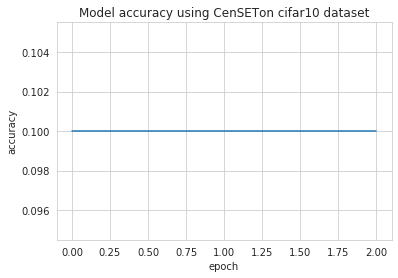

------------END of experiment 'Model accuracy using CenSET' for dataset: cifar10------------


In [171]:
K.clear_session()

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Each index i represents an expeirment
datasets=[cifar10] # fashion_mnist, cifar10 -- only supports cifar10 atm
maxepoches=[10]
pruning_approachs=["CenSET",]
experiment_titles = ["Model accuracy using CenSET",]
run_experiments(datasets,maxepoches, pruning_approachs ,experiment_titles)



### TODO 
 
- uncover why edge amount flucuates durng procedure 

Bigger TODOS
- Ideally find a way to go between the weights / layers / mask and the adj matrix using matrix operations.
- Correctly create neural network from weighted mask, 


